In [1]:
# check version of keras_vggface
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import keras_vggface
# print version
print(keras_vggface.__version__)

Using TensorFlow backend.


0.6


In [2]:
from keras_vggface.vggface import VGGFace
# create a vggface model
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
model.summary()

In [ ]:
model.inputs

In [ ]:
model.outputs

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from os.path import join
from os import listdir
import pandas as pd
import seaborn as sns

In [2]:
grid_dir = join(os.getcwd(), "grid")
speakers = listdir(grid_dir)
vocab = list()
aligns = dict()

for speaker in speakers:
    speaker_align_path = join(grid_dir, speaker, "align")
    speaker_vid_names = listdir(speaker_align_path)
    for speaker_vid_name in speaker_vid_names:
        df = pd.read_csv(join(speaker_align_path, speaker_vid_name), 
                         delimiter = " ", names=["start", "end", "utter"])        
        for row in np.array(df):            
            if row[2] not in vocab:
                vocab.append(row[2])        
        aligns[speaker_vid_name.replace(".align", "")] = df

In [3]:
print(vocab)
print(len(vocab))
# print(aligns)

['sil', 'bin', 'blue', 'at', 'f', 'two', 'now', 'three', 'soon', 'four', 'please', 'five', 'again', 'l', 'six', 'seven', 'eight', 'nine', 's', 'one', 'zero', 'z', 'by', 'm', 'in', 'e', 'r', 'sp', 'with', 'g', 't', 'green', 'a', 'h', 'n', 'u', 'b', 'o', 'i', 'red', 'white', 'lay', 'd', 'k', 'q', 'x', 'y', 'j', 'place', 'c', 'p', 'v', 'set']
53


In [8]:
import dill

with open("train_dump_x_y", "rb") as dill_file:
    X, Y = dill.load(dill_file)

In [4]:
import dill

with open("vocab_dump", "wb") as f:
    dill.dump(vocab, f)

In [9]:
X.nbytes, Y.nbytes

(614400000, 31800000)

In [10]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices('GPU'))

2.0.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><h1 style="text-align:center;">PREPROCESSING DONE</h1><hr>

In [ ]:
ends=aligns["bbaf2n"]["end"]
for i in ends:
    print(i/1000)

In [ ]:
from keras_vggface.utils import preprocess_input
from mtcnn import MTCNN
import matplotlib.pyplot as  plt
%matplotlib inline

detector = MTCNN()
grid_dir = os.path.join(os.getcwd(), "grid")
speakers = os.listdir(grid_dir)
X = np.zeros((len(speakers), 1000, 75, 2048), dtype=np.float32)
Y = np.zeros((len(speakers), 1000, 75, len(vocab)))

for num_speaker, speaker in enumerate(speakers):    
    speaker_vids_path = os.path.join(grid_dir, speaker, speaker)
    speaker_vids = os.listdir(speaker_vids_path)
    
    for i, speaker_vid in enumerate(speaker_vids):
        speaker_vids[i] = speaker_vid.replace(".mpg", "")
        
    for num_vid, speaker_vid in enumerate(speaker_vids):
        df = aligns[speaker_vid]
        starts = df["start"]
        ends = df["end"]
        utters = df["utter"]
        if num_vid%20 == 0:
            print(num_vid)
        cam = cv2.VideoCapture(os.path.join(speaker_vids_path, speaker_vid+".mpg")) 
        frame_buffer = np.zeros((75, 224, 224, 3), dtype=np.float32)
        for num_frame in range(75):                       
            ret, frame = cam.read()              
            if frame is not None:
                frame=frame.astype(np.float32)  
#                 frame/=255
#                 plt.imshow(frame)
#                 plt.show()
#                 frame*=255
                #frame=frame/255    
                results = detector.detect_faces(frame)
                if len(results) >= 1:
                    x1, y1, width, height = results[0]['box']
                    x2, y2 = x1 + width, y1 + height
                    frame = frame[y1:y2, x1:x2]
#                 frame/=255
#                 plt.imshow(frame)
#                 plt.show()
#                 frame*=255
#                 input()
                frame = cv2.resize(frame, (224, 224)).astype(np.float32)                             
                
                #frame = np.reshape(frame, (1, 224, 224, 3))
                #frame = np.expand_dims(frame, axis = 0)
                frame_buffer[num_frame] = frame

            frame_utter = None
            for i_end, end in enumerate(ends):                
                if num_frame < end/1000:
                    frame_utter = utters[i_end]
                    break            
            assert frame_utter
            Y[num_speaker, num_vid, num_frame, vocab.index(frame_utter)] = 1
            
        frame_buffer = preprocess_input(frame_buffer)
        X[num_speaker, num_vid] = model.predict(frame_buffer)        
                                                         
# print(speaker_vids)

In [ ]:
import dill
with open("train_dump_x_y", "wb") as dill_file:
    dill.dump((X,Y), dill_file)

In [ ]:
from keras_vggface.utils import preprocess_input
x = preprocess_input(np.expand_dims(frame_buffer[19]*255, axis=0), version=2)
p = model.predict(x)
num=0
for ip in p[0]:
    if not ip == 0:
        num+=1
        print(ip)
num

In [ ]:
p=X[0,6,0]
num=0
for ip in p:
    if not ip == 0:
        num+=1
        print(ip)
num

In [ ]:
Y[0,969,29]
# vocab[0]

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[0], Y[0],
                                                    test_size=0.3, random_state=69)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,
                                                    test_size=0.33, random_state=69)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((700, 75, 2048),
 (700, 75, 53),
 (201, 75, 2048),
 (201, 75, 53),
 (99, 75, 2048),
 (99, 75, 53))

In [37]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
a1 = keras.layers.LSTM(1024, return_sequences=True)(ip)
print(a1)
a2 = keras.layers.Dense(512, activation="relu")(a1)
a3 = keras.layers.Dense(128, activation="tanh")(a2)
# op = keras.layers.Dense(len(vocab), activcation="softmax")(a3)
op = keras.layers.Dense(53, activation="softmax")(a3)

model1=keras.models.Model(inputs=ip, outputs=op)
model1.summary()
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.fit(x_train,y_train, batch_size=64, epochs=200)
print(op)

Tensor("lstm_5/Identity:0", shape=(None, 75, 1024), dtype=float32)
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 75, 2048)]        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 75, 1024)          12587008  
_________________________________________________________________
dense_29 (Dense)             (None, 75, 512)           524800    
_________________________________________________________________
dense_30 (Dense)             (None, 75, 128)           65664     
_________________________________________________________________
dense_31 (Dense)             (None, 75, 53)            6837      
Total params: 13,184,309
Trainable params: 13,184,309
Non-trainable params: 0
_________________________________________________________________
Train on 700 samples
Epoch 1/200
700/700 [===

700/700 [==============================] - 1s 2ms/sample - loss: 0.4593 - accuracy: 0.8582
Epoch 148/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4949 - accuracy: 0.8483
Epoch 149/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4679 - accuracy: 0.8552
Epoch 150/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.5022 - accuracy: 0.8435
Epoch 151/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4816 - accuracy: 0.8492
Epoch 152/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4742 - accuracy: 0.8522
Epoch 153/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4552 - accuracy: 0.8593
Epoch 154/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4667 - accuracy: 0.8546
Epoch 155/200
700/700 [==============================] - 1s 2ms/sample - loss: 0.4929 - accuracy: 0.8460
Epoch 156/200
700/700 [==============================] - 1s 2ms/sampl

In [ ]:
model1.evaluate(x_test, y_test)

In [41]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(512, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(256, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
a1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(ip_red2_drop)
a1_drop = keras.layers.Dropout(0.3)(a1)

a2 = keras.layers.Dense(256, activation="relu")(a1_drop)
a2=keras.layers.Dropout(0.3)(a2)
a3 = keras.layers.Dense(128, activation="relu")(a2)
op = keras.layers.Dense(len(vocab), activation="softmax")(a3)

model2=keras.models.Model(inputs=ip, outputs=op)
model2.summary()
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(x_train,y_train, batch_size=64, epochs=150)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 75, 2048)]        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 75, 2048)          0         
_________________________________________________________________
dense_37 (Dense)             (None, 75, 512)           1049088   
_________________________________________________________________
dropout_31 (Dropout)         (None, 75, 512)           0         
_________________________________________________________________
dense_38 (Dense)             (None, 75, 256)           131328    
_________________________________________________________________
dropout_32 (Dropout)         (None, 75, 256)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 75, 256)           394

700/700 [==============================] - 0s 600us/sample - loss: 0.1190 - accuracy: 0.9560
Epoch 136/150
700/700 [==============================] - 0s 600us/sample - loss: 0.1127 - accuracy: 0.9585
Epoch 137/150
700/700 [==============================] - 0s 585us/sample - loss: 0.1183 - accuracy: 0.9570
Epoch 138/150
700/700 [==============================] - 0s 608us/sample - loss: 0.1148 - accuracy: 0.9584
Epoch 139/150
700/700 [==============================] - 0s 593us/sample - loss: 0.1148 - accuracy: 0.9590
Epoch 140/150
700/700 [==============================] - 0s 586us/sample - loss: 0.1118 - accuracy: 0.9592
Epoch 141/150
700/700 [==============================] - 0s 600us/sample - loss: 0.1088 - accuracy: 0.9607
Epoch 142/150
700/700 [==============================] - 0s 600us/sample - loss: 0.1032 - accuracy: 0.9621
Epoch 143/150
700/700 [==============================] - 0s 585us/sample - loss: 0.0991 - accuracy: 0.9633
Epoch 144/150
700/700 [============================

In [ ]:
pred = model2.predict(x_test)
print(pred.shape)
frame_corr = 0
frames = 0
for i, row in enumerate(pred):
    for j, frame_pred in enumerate(row):
        frames+=1
        if np.argmax(frame_pred) == np.argmax(y_test[i, j]):
            frame_corr += 1
print(frame_corr, frames, frame_corr/frames)

In [26]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(256*2, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(128*2, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(64*2, return_sequences=True))
a1 = bi_lstm(ip_red2_drop)

t_model1 = keras.models.Model(inputs=ip, outputs=a1)

attn_res = keras.layers.Attention()([a1, a1])

t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

res = tf.concat([a1, attn_res], axis = -1)
res = keras.layers.Dropout(0.3)(res)

# x = keras.layers.Dense(512, activation="relu")(res)
# x=keras.layers.Dropout(0.2)(x)
a2 = keras.layers.Dense(256, activation="relu")(res)
a2=keras.layers.Dropout(0.3)(a2)
a3 = keras.layers.Dense(128, activation="relu")(a2)
op = keras.layers.Dense(len(vocab), activation="softmax")(a3)

model3=keras.models.Model(inputs=ip, outputs=op)
model3.summary()
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(x_train,y_train, batch_size=64, epochs=200)
# print(t_model1.summary(),end="\n--------------\n")
# print(t_model2.summary(),end="\n--------------\n")


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 75, 2048)]   0                                            
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 75, 2048)     0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 75, 512)      1049088     dropout_20[0][0]                 
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 75, 512)      0           dense_20[0][0]                   
___________________________________________________________________________________________

700/700 [==============================] - 0s 601us/sample - loss: 0.0996 - accuracy: 0.9641
Epoch 123/200
700/700 [==============================] - 0s 600us/sample - loss: 0.0982 - accuracy: 0.9637
Epoch 124/200
700/700 [==============================] - 0s 614us/sample - loss: 0.1024 - accuracy: 0.9624
Epoch 125/200
700/700 [==============================] - 0s 614us/sample - loss: 0.1031 - accuracy: 0.9626
Epoch 126/200
700/700 [==============================] - 0s 614us/sample - loss: 0.1048 - accuracy: 0.9617
Epoch 127/200
700/700 [==============================] - 0s 600us/sample - loss: 0.1021 - accuracy: 0.9620
Epoch 128/200
700/700 [==============================] - 0s 614us/sample - loss: 0.0961 - accuracy: 0.9646
Epoch 129/200
700/700 [==============================] - 0s 600us/sample - loss: 0.1018 - accuracy: 0.9633
Epoch 130/200
700/700 [==============================] - 0s 614us/sample - loss: 0.1019 - accuracy: 0.9626
Epoch 131/200
700/700 [============================

In [84]:
from jiwer import wer

def get_sent_from_preds(labels): #(bs, 75, 53)
    labels = np.argmax(labels, axis=2) #(bs, 75)
    res = []
    for vid_label in labels:
        vid_res = ["sil"]
        for word_index in vid_label:
            word = vocab[word_index]
            if not vid_res[-1] == word:
                vid_res.append(word)
        res.append(" ".join(vid_res).strip())
    return res

def get_wer(model, x, y):
    return wer(get_sent_from_preds(y), get_sent_from_preds(model.predict(x)[1]))

In [83]:
len(model4.predict(x_test))

2

In [108]:
get_wer(model4, x_test, y_test)

0.13159528243327126

In [39]:
x = 10
get_sent_from_preds(y_test[:x]), get_sent_from_preds(model1.predict(x_test[:x]))

(['sil set blue at g nine soon sil',
  'sil bin green at n four now sil',
  'sil place blue by p five again sil',
  'sil set green at c three soon sil',
  'sil place red by d three again sil',
  'sil place white with y three soon sil',
  'sil place green in d six please sil',
  'sil bin green in n three again sil',
  'sil set green in b nine soon sil',
  'sil lay white at r eight please sil'],
 ['sil set sil blue at u g zero nine zero soon two soon sil',
  'sil place blue green in at f five four now sil',
  'sil place blue by p v five v five now again sil',
  'sil set green in c three soon four soon sil',
  'sil place green red by k d seven three again sil',
  'sil place green red white red green with in three soon three soon sil',
  'sil set place green in z c seven six seven please six please sil',
  'sil bin green in a n i five three again sil',
  'sil set green in green by p in at by y nine in zero soon sil',
  'sil lay white at i h eight five please seven six now sil'])

[[1.02780863e-02 1.98178414e-02 3.22985754e-02 ... 8.68121407e-07
  4.43965412e-07 1.82224390e-07]
 [2.54249751e-03 6.79539312e-03 1.47261271e-02 ... 1.74323657e-07
  9.30165571e-08 4.00493831e-08]
 [5.20501939e-04 1.84979389e-03 5.27676874e-03 ... 3.25707460e-08
  1.82970889e-08 8.34355113e-09]
 ...
 [3.75873646e-05 5.88319915e-05 8.75084784e-05 ... 6.05027666e-02
  4.11833911e-02 2.38610683e-02]
 [3.52122325e-05 5.75043233e-05 9.00507716e-05 ... 7.54405974e-02
  5.84238179e-02 3.96820538e-02]
 [3.00871568e-05 5.15425957e-05 8.54843457e-05 ... 9.09919804e-02
  8.26084285e-02 6.91426213e-02]]


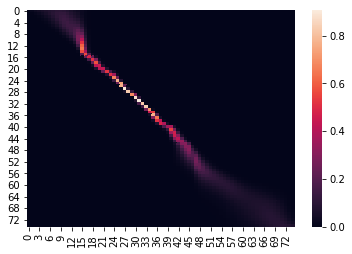

In [107]:
from scipy.special import softmax
# model3.evaluate(x_test, y_test)
sample = np.expand_dims(x_test[16], axis=0)

# print(t_model1.predict(sample).shape)
t1_preds = np.squeeze(t_model3.predict(sample))
t1_preds.shape

t2_preds = np.squeeze(t_model4.predict(sample))

scores = np.zeros((75, 75))
for i, frame_pred in enumerate(t1_preds):
    attn_res = np.zeros((256))
    for j, other_frame_pred in enumerate(t1_preds):
        scores[i, j] = np.sum(frame_pred * other_frame_pred)
    scores[i] = softmax(scores[i])
    for j, other_frame_pred in enumerate(t1_preds):
        attn_res += scores[i, j] * other_frame_pred
#     print(t2_preds[i])
#     print(t2_preds[i] - attn_res)
#     break
    
    
# print(t_model2.predict(sample).shape)
print(scores)
sns.heatmap(scores)

In [ ]:
from jiwer import wer
def condense(preds):
    global vocab
    last_pred = -1
    last_pred_freq = 0
    fin_preds = []
    for pred in preds:
        if not pred == last_pred:
            if not len(fin_preds) == 0:
                fin_preds[len(fin_preds) - 1][1] = last_pred_freq + 1
            last_pred_freq = 0
            fin_preds.append([pred, 0])
            last_pred = pred
        else:
            last_pred_freq += 1 
    s=""
    for pred, freq in fin_preds:
        s += " " + vocab[pred]
    s = s.strip()    
    return fin_preds, s

ground_truth = []
hypo = []
all_preds = model4.predict(x_test)
for sample_pred, label in zip(all_preds, y_test):
#     sample = np.expand_dims(sample, axis=0)
#     preds = np.squeeze(model3.predict(sample))
    preds = np.argmax(sample_pred, axis=1)
    labels = np.argmax(label, axis=1)
    
    _, s = condense(preds)
    hypo.append(" ".join(list(s)))
    _, s = condense(labels)
    ground_truth.append(" ".join(list(s)))
    
print(wer(ground_truth, hypo))
#     print(preds,"\n", condense(preds))
#     print(labels,"\n", condense(labels))
    
#     print("\n----------------------\n")

In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(512, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(256, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128*2, return_sequences=True))
a1 = bi_lstm(ip_red2_drop)

# t_model1 = keras.models.Model(inputs=ip, outputs=a1)

# attn_res = keras.layers.Attention()([a1, a1])

# t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

# res = tf.concat([a1, attn_res], axis = -1)
a1 = keras.layers.Dropout(0.3)(a1)

# x = keras.layers.Dense(512, activation="relu")(res)
# x=keras.layers.Dropout(0.2)(x)
a2 = keras.layers.Dense(256, activation="relu")(a1)
a2=keras.layers.Dropout(0.1)(a2)
a3 = keras.layers.Dense(128, activation="relu")(a2)

t_model1 = keras.models.Model(inputs=ip, outputs=a3)

attn_res = keras.layers.Attention()([a3, a3])

t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

res = tf.concat([a3, attn_res], axis = -1)

a4= keras.layers.Dense(64, activation="relu")(res)
op = keras.layers.Dense(len(vocab), activation="softmax")(a4)

model4=keras.models.Model(inputs=ip, outputs=op)
model4.summary()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(x_train,y_train, batch_size=64, epochs=350)
# print(t_model1.summary(),end="\n--------------\n")
# print(t_model2.summary(),end="\n--------------\n")


<h1>initialise with lang models weights and make it non trainable</h1>

In [106]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(256*2, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(128*2, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(64*2, return_sequences=True))
a1 = bi_lstm(ip_red2_drop)

t_model1 = keras.models.Model(inputs=ip, outputs=a1)

attn_res = keras.layers.Attention()([a1, a1])

t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

res = tf.concat([a1, attn_res], axis = -1)
res = keras.layers.Dropout(0.3)(res)

# x = keras.layers.Dense(512, activation="relu")(res)
# x=keras.layers.Dropout(0.2)(x)
a2 = keras.layers.Dense(256, activation="relu")(res)
a2=keras.layers.Dropout(0.3)(a2)
a3 = keras.layers.Dense(128, activation="relu")(a2)
a4 = keras.layers.Dense(len(vocab), activation="softmax")(a3)
a4_t = keras.layers.Dense(128, activation="relu")(a4)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))
a5 = bi_lstm(a4_t)

t_model3 = keras.models.Model(inputs=ip, outputs=a5)

attn_res2 = keras.layers.Attention()([a5, a5])

t_model4 = keras.models.Model(inputs=ip, outputs=attn_res2)

res2 = tf.concat([a5, attn_res2], axis = -1)
x = keras.layers.Dense(256, activation="relu")(res2)
x = keras.layers.Dense(128, activation="relu")(x)
# op = keras.layers.Dense(len(vocab), activation="softmax")(tf.concat([x, a3], axis = -1))
op = keras.layers.Dense(len(vocab), activation="softmax")(x)

model4=keras.models.Model(inputs=ip, outputs=[a4, op])
model4.summary()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              loss_weights=[0.5, 2])

model4.fit(x_train,[y_train, y_train], batch_size=64, epochs=210)
# print(t_model1.summary(),end="\n--------------\n")
# print(t_model2.summary(),end="\n--------------\n")


Model: "model_118"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 75, 2048)]   0                                            
__________________________________________________________________________________________________
dropout_130 (Dropout)           (None, 75, 2048)     0           input_30[0][0]                   
__________________________________________________________________________________________________
dense_190 (Dense)               (None, 75, 512)      1049088     dropout_130[0][0]                
__________________________________________________________________________________________________
dropout_131 (Dropout)           (None, 75, 512)      0           dense_190[0][0]                  
__________________________________________________________________________________________

700/700 [==============================] - 1s 882us/sample - loss: 1.2173 - dense_194_loss: 0.5478 - dense_198_loss: 0.4717 - dense_194_accuracy: 0.8302 - dense_198_accuracy: 0.8508
Epoch 60/210
700/700 [==============================] - 1s 837us/sample - loss: 1.1592 - dense_194_loss: 0.5324 - dense_198_loss: 0.4465 - dense_194_accuracy: 0.8371 - dense_198_accuracy: 0.8574
Epoch 61/210
700/700 [==============================] - 1s 882us/sample - loss: 1.1539 - dense_194_loss: 0.5336 - dense_198_loss: 0.4435 - dense_194_accuracy: 0.8351 - dense_198_accuracy: 0.8582
Epoch 62/210
700/700 [==============================] - 1s 904us/sample - loss: 1.1273 - dense_194_loss: 0.5219 - dense_198_loss: 0.4331 - dense_194_accuracy: 0.8400 - dense_198_accuracy: 0.8607
Epoch 63/210
700/700 [==============================] - 1s 926us/sample - loss: 1.0973 - dense_194_loss: 0.5140 - dense_198_loss: 0.4202 - dense_194_accuracy: 0.8431 - dense_198_accuracy: 0.8650
Epoch 64/210
700/700 [================

700/700 [==============================] - 1s 859us/sample - loss: 0.4039 - dense_194_loss: 0.2714 - dense_198_loss: 0.1338 - dense_194_accuracy: 0.9105 - dense_198_accuracy: 0.9501
Epoch 143/210
700/700 [==============================] - 1s 859us/sample - loss: 0.3822 - dense_194_loss: 0.2638 - dense_198_loss: 0.1253 - dense_194_accuracy: 0.9138 - dense_198_accuracy: 0.9523
Epoch 144/210
700/700 [==============================] - 1s 882us/sample - loss: 0.3611 - dense_194_loss: 0.2562 - dense_198_loss: 0.1165 - dense_194_accuracy: 0.9157 - dense_198_accuracy: 0.9564
Epoch 145/210
700/700 [==============================] - 1s 859us/sample - loss: 0.3674 - dense_194_loss: 0.2574 - dense_198_loss: 0.1194 - dense_194_accuracy: 0.9150 - dense_198_accuracy: 0.9550
Epoch 146/210
700/700 [==============================] - 1s 859us/sample - loss: 0.3416 - dense_194_loss: 0.2461 - dense_198_loss: 0.1093 - dense_194_accuracy: 0.9201 - dense_198_accuracy: 0.9584
Epoch 147/210
700/700 [===========

In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(256*2, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(128*2, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(64*2, return_sequences=True))
a1 = bi_lstm(ip_red2_drop)

t_model1 = keras.models.Model(inputs=ip, outputs=a1)

attn_res = keras.layers.Attention()([a1, a1])

t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

res = tf.concat([a1, attn_res], axis = -1)
res = keras.layers.Dropout(0.3)(res)

# x = keras.layers.Dense(512, activation="relu")(res)
# x=keras.layers.Dropout(0.2)(x)

bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))
a5 = bi_lstm(res)

t_model3 = keras.models.Model(inputs=ip, outputs=a5)

attn_res2 = keras.layers.Attention()([a5, a5])

t_model4 = keras.models.Model(inputs=ip, outputs=attn_res2)

res2 = tf.concat([a5, attn_res2], axis = -1)

bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))
a5 = bi_lstm(res2)

t_model5 = keras.models.Model(inputs=ip, outputs=a5)

attn_res2 = keras.layers.Attention()([a5, a5])

t_model6 = keras.models.Model(inputs=ip, outputs=attn_res2)

res3 = tf.concat([a5, attn_res2], axis = -1)

bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))
a5 = bi_lstm(res3)

t_model7 = keras.models.Model(inputs=ip, outputs=a5)

attn_res2 = keras.layers.Attention()([a5, a5])

t_model8 = keras.models.Model(inputs=ip, outputs=attn_res2)

res4 = tf.concat([a5, attn_res2], axis = -1)

x = keras.layers.Dense(256, activation="relu")(res4)
x = keras.layers.Dense(128, activation="relu")(x)
# op = keras.layers.Dense(len(vocab), activation="softmax")(tf.concat([x, a3], axis = -1))
op = keras.layers.Dense(len(vocab), activation="softmax")(x)

model4=keras.models.Model(inputs=ip, outputs=op)
model4.summary()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(x_train, y_train, batch_size=64, epochs=210)
# print(t_model1.summary(),end="\n--------------\n")
# print(t_model2.summary(),end="\n--------------\n")


<h1>lang model 1</h1>

In [ ]:
sents = []
for key in aligns:
    sent = " ".join(list(aligns[key].loc[:, "utter"])).strip()
    sent = sent.replace(" sp", "")
    sents.append(sent)

In [ ]:
sents[132]

In [ ]:
lang_x = np.zeros((len(sents), 7, len(vocab)))
lang_y = np.zeros((len(sents), 7, len(vocab)))

for i, sent in enumerate(sents):
    print(i)
    for j, word in enumerate(sent.split()):
        if j < 7:
            lang_x[i, j, vocab.index(word)] = 1
            
    for j, word in enumerate(sent.split()):
#         print(j)
        if j > 0:
            lang_y[i, j - 1, vocab.index(word)] = 1

In [ ]:
lang_y.shape

In [ ]:
import tensorflow as tf
from tensorflow import keras

ip = keras.layers.Input((None, len(vocab)))
x = keras.layers.Dense(128, activation="relu")(ip)
x = keras.layers.LSTM(256, return_sequences=True)(x)
x = keras.layers.Dense(128, activation="relu")(x)
op = keras.layers.Dense(len(vocab), activation="softmax")(x)

lang_model = keras.models.Model(inputs=ip, outputs=op)
lang_model.summary()

In [ ]:
lang_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lang_model.fit(lang_x, lang_y, batch_size=64, epochs=500)

In [ ]:
def encode(sent):
    global vocab
    res = np.zeros((1, len(sent.split()), 53))
    for i, word in enumerate(sent.split()):
        res[0, i, vocab.index(word)] = 1
    return res

def decode(pred):
    pred = pred[0]
    ret = ""
    for t in pred:
         ret += " " + vocab[np.argmax(t)]
    return ret

sample = sents[10]

hist = ""
for word in sample.split():
    hist += " " + word
    hist = hist.strip()
    temp = lang_model.predict(encode(word))
    pred = decode(temp)
    temp = temp[0, -1]    
    print("hist:", hist)
    s = np.argsort(temp)
    s=s[-5:]
    for si in s:
        print(vocab[si], temp[si],  end=",")
        
    print("\npred:", pred)

<h1>Lang model 2</h1>

In [27]:
sents = []
for key in aligns:
    sent = " ".join(list(aligns[key].loc[:, "utter"])).strip()
    sent = sent.replace(" sp", "")
    sents.append(sent)

In [28]:
lang_x = np.zeros((len(sents) * 7, len(vocab)))
lang_y = np.zeros((len(sents) * 7, len(vocab)))

for i, sent in enumerate(sents):
    print(i)
    for j, word in enumerate(sent.split()):
        if j == 7:
            break
        lang_x[i*7 + j, vocab.index(word)] = 1
            
    for j, word in enumerate(sent.split()):
        if j == 0:
            continue
        lang_y[i*7 + j - 1, vocab.index(word)] = 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
np.random.seed(69)
np.random.shuffle(lang_x)
np.random.seed(69)
np.random.shuffle(lang_y)

In [30]:
import tensorflow as tf
from tensorflow import keras

ip = keras.layers.Input(len(vocab))
x = keras.layers.Dense(128, activation="relu")(ip)
x = keras.layers.Dense(256, activation="tanh")(x)
x = keras.layers.Dense(128, activation="relu")(x)
op = keras.layers.Dense(len(vocab), activation="softmax")(x)

lang_model = keras.models.Model(inputs=ip, outputs=op)
lang_model.summary()

lang_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lang_model.fit(lang_x, lang_y, batch_size=64, epochs=150)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               6912      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 53)                6837      
Total params: 79,669
Trainable params: 79,669
Non-trainable params: 0
_________________________________________________________________
Train on 7000 samples
Epoch 1/150
7000/7000 [==============================] - 1s 93us/sample - loss: 2.4209 - accuracy:

Epoch 68/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4864 - accuracy: 0.3364
Epoch 69/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4868 - accuracy: 0.3283
Epoch 70/150
7000/7000 [==============================] - 0s 31us/sample - loss: 1.4858 - accuracy: 0.3387
Epoch 71/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4873 - accuracy: 0.3346
Epoch 72/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4871 - accuracy: 0.3279
Epoch 73/150
7000/7000 [==============================] - 0s 34us/sample - loss: 1.4857 - accuracy: 0.3386
Epoch 74/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4858 - accuracy: 0.3377
Epoch 75/150
7000/7000 [==============================] - 0s 33us/sample - loss: 1.4857 - accuracy: 0.3320
Epoch 76/150
7000/7000 [==============================] - 0s 34us/sample - loss: 1.4861 - accuracy: 0.3341
Epoch 77/150
7000/7000 [=============

In [ ]:
def encode(sent):
    global vocab
    res = np.zeros((1, 53))
    for i, word in enumerate(sent.split()):
        res[0, vocab.index(word)] = 1
    return res

def decode(pred):
    pred = pred[0]
    return vocab[np.argmax(pred)]

sample = sents[10]

for word in sample.split():
    temp = lang_model.predict(encode(word))
    pred = decode(temp)
    temp = temp[0]    
    print("word:", word)
    s = np.argsort(temp)
    s=s[-5:]
    for si in s:
        print(vocab[si], temp[si],  end=",")   
    print()

<h1>final</h1>

In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

ip = keras.layers.Input(shape = (75, 2048), batch_size = None)
ip_drop = keras.layers.Dropout(0)(ip)
ip_red1 = keras.layers.Dense(512, activation="relu")(ip_drop)
ip_red1_drop = keras.layers.Dropout(0.3)(ip_red1)
ip_red2 = keras.layers.Dense(256, activation="relu")(ip_red1_drop)
ip_red2_drop = keras.layers.Dropout(0.2)(ip_red2)
bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128*2, return_sequences=True))
a1 = bi_lstm(ip_red2_drop)

# t_model1 = keras.models.Model(inputs=ip, outputs=a1)

# attn_res = keras.layers.Attention()([a1, a1])

# t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

# res = tf.concat([a1, attn_res], axis = -1)
a1 = keras.layers.Dropout(0.3)(a1)

# x = keras.layers.Dense(512, activation="relu")(res)
# x=keras.layers.Dropout(0.2)(x)
a2 = keras.layers.Dense(256, activation="relu")(a1)
a2=keras.layers.Dropout(0.1)(a2)
a3 = keras.layers.Dense(128, activation="relu")(a2)

t_model1 = keras.models.Model(inputs=ip, outputs=a3)

attn_res = keras.layers.Attention()([a3, a3])

t_model2 = keras.models.Model(inputs=ip, outputs=attn_res)

res = tf.concat([a3, attn_res], axis = -1)

a4= keras.layers.Dense(64, activation="relu")(res)
op = keras.layers.Dense(len(vocab), activation="softmax")(a4)

model4=keras.models.Model(inputs=ip, outputs=op)
model4.summary()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(x_train,y_train, batch_size=64, epochs=100)
# print(t_model1.summary(),end="\n--------------\n")
# print(t_model2.summary(),end="\n--------------\n")


<h1>Attention visual</h1>

In [ ]:
from scipy.special import softmax
# model3.evaluate(x_test, y_test)
sample = np.expand_dims(x_test[86], axis=0)

# print(t_model1.predict(sample).shape)
t1_preds = np.squeeze(t_model1.predict(sample))
t1_preds.shape

t2_preds = np.squeeze(t_model2.predict(sample))

scores = np.zeros((75, 75))
for i, frame_pred in enumerate(t1_preds):
    attn_res = np.zeros((128))
    for j, other_frame_pred in enumerate(t1_preds):
        scores[i, j] = np.sum(frame_pred * other_frame_pred)
    scores[i] = softmax(scores[i])
    for j, other_frame_pred in enumerate(t1_preds):
        attn_res += scores[i, j] * other_frame_pred
#     print(t2_preds[i])
#     print(t2_preds[i] - attn_res)
#     break
    
    
# print(t_model2.predict(sample).shape)
print(scores)
sns.heatmap(scores)

<h1>cer calc , cer without lm 0.122</h1>

In [ ]:
from jiwer import wer
def condense(preds):
    global vocab
    last_pred = -1
    last_pred_freq = 0
    fin_preds = []
    for pred in preds:
        if not pred == last_pred:
            if not len(fin_preds) == 0:
                fin_preds[len(fin_preds) - 1][1] = last_pred_freq + 1
            last_pred_freq = 0
            fin_preds.append([pred, 0])
            last_pred = pred
        else:
            last_pred_freq += 1 
    s=""
    for pred, freq in fin_preds:
        s += " " + vocab[pred]
    s = s.strip()    
    return fin_preds, s

ground_truth = []
hypo = []
fin_preds = []
fin_labels = []

all_preds = model4.predict(x_test)
for sample_pred, label in zip(all_preds, y_test):
#     sample = np.expand_dims(sample, axis=0)
#     preds = np.squeeze(model3.predict(sample))
    preds = np.argmax(sample_pred, axis=1)
    labels = np.argmax(label, axis=1)
    
    fin_pred, s = condense(preds)
    fin_preds.append(fin_pred)
    hypo.append(" ".join(list(s)))
    
    fin_label, s = condense(labels)
    fin_labels.append(fin_label)
    ground_truth.append(" ".join(list(s)))
    
print(wer(ground_truth, hypo))
#     print(preds,"\n", condense(preds))
#     print(labels,"\n", condense(labels))
    
#     print("\n----------------------\n")

In [ ]:
for x in [1,3,4, 5]:
    fin_preds_x = fin_preds[x]
    fin_labels_x = fin_labels[x]
    for fin_pred in fin_preds_x:
        print(vocab[fin_pred[0]], ", ", fin_pred[1], end="  ")
    print()
    for fin_pred in fin_labels_x:
        print(vocab[fin_pred[0]], ", ", fin_pred[1], end="  ")
    print("\n\n----------------------------------")

In [ ]:
print(all_preds[x, 27:36, vocab.index("three")])

static lambda with shallow fusion won't work

In [35]:
def encode(sent):
    global vocab
    res = np.zeros((1, 53))
    for i, word in enumerate(sent.split()):
        res[0, vocab.index(word)] = 1
    return res

def decode(pred):
    pred = pred[0]
    return vocab[np.argmax(pred)]

def predict(model, lang_model, lmbda, x): #x.shape = (bs, 75, 2048)
    m_preds = model.predict(x) #shape = (bs, 75, 53)
    vid_preds = []
    for i, vid_pred in enumerate(m_preds):
        fin_preds = []   
        mt_preds=[]
        for frame_num, frame_pred in enumerate(vid_pred):
            frame_pred_word = vocab[np.argmax(frame_pred)]            
            if frame_num == 0:
                fin_preds.append(frame_pred_word)                
                mt_preds.append(frame_pred_word)
                continue
            if fin_preds[-1]=="sil" and len(fin_preds) > 1:
                break
            if frame_pred_word == "sil" and not len(fin_preds) == 1:
                fin_preds.append("sil")
                mt_preds.append("sil")
                break
            if not frame_pred_word == mt_preds[-1]:
                mt_preds.append(frame_pred_word)            
                lm_pred = lang_model.predict(encode(fin_preds[-1]))[0]                
                assert lm_pred.shape == (53, )
                sf_pred = np.log(frame_pred) + lmbda * np.log(lm_pred)
                sf_pred_word = vocab[np.argmax(sf_pred)]
                fin_preds.append(sf_pred_word)                
        vid_preds.append(" ".join(fin_preds).strip())
    return vid_preds


# test_fin_preds = predict(model4, lang_model, 1, x_test)

In [ ]:
def gen_gt(labels): #(bs, 75, 53)
    labels = np.argmax(labels, axis=2) #(bs, 75)
    res = []
    for vid_label in labels:
        vid_res = ["sil"]
        for word_index in vid_label:
            word = vocab[word_index]
            if not vid_res[-1] == word:
                vid_res.append(word)
        res.append(" ".join(vid_res).strip())
    return res

In [44]:
m_preds = model4.predict(x_train)
lang_integ_x_m = np.zeros((x_train.shape[0]*7, len(vocab)))
lang_integ_x_lang = np.zeros((x_train.shape[0]*7, len(vocab)))
lang_integ_y = np.zeros((x_train.shape[0]*7, len(vocab)))

for i, sample in enumerate(x_train):
    for j, frame in sample:
        

In [ ]:
test_sents

In [ ]:
test_fin_preds

In [ ]:
from jiwer import wer
wer(test_sents, test_fin_preds)

In [ ]:
np.arange(0,5,0.4)

In [ ]:
from jiwer import wer

for lmbda in np.arange(0,2,0.1):
    print(lmbda,  wer(test_sents, predict(model4, lang_model, lmbda, x_test)))

In [36]:
wer(get_sent_from_preds(y_test), predict(model3, lang_model, 0, x_test))

0.15890751086281812

In [86]:
model4.save("double_attention_250e_0.12_wer")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: double_attention_250e_0.12_wer\assets


In [98]:
model4 = keras.models.load_model("double_attention_250e_0.12_wer")

In [91]:
del temp